<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [3]:
%%capture
!pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [4]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [13]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 8 * 3600 # equal to 8 hours
TARGET_NAME = 'Средний рейтинг'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [7]:
INPUT_DIR = '../input/tadmo-faru-pm/'

In [8]:
train_data = pd.read_csv(INPUT_DIR + 'train.csv')
print(train_data.shape)
train_data.head()

(52304, 13)


,ID,Название,Жанры,Язык,Описание,Популярность,Производители,Дата релиза,Бюджет,Прибыль,Длительность,Средний рейтинг,Кол-во отзывов
0,471925,I Scream When I Knew What You Did in Friday th...,Comedy-Horror,pt,Seven years after the massacre of the first fi...,9.218,Necrófilos Produções Artísticas,2011-10-20,0.0,0.0,82.0,5.5,4.0
1,416371,La notte non fa più paura,Drama,it,A group of workers try overcoming their differ...,0.600,NaN,2016-05-03,0.0,0.0,65.0,5.8,3.0
2,669656,MOTOAKI FURUKAWA with VOYAGER LIVE 2008 TOKYO ...,Music,ja,Recorded live in Tokyo in September 2008 and K...,0.600,Studio AS,2009-08-25,0.0,0.0,70.0,0.0,0.0
3,145218,Brorsan Såsett - En kärlekshistoria,NaN,sv,NaN,0.600,NaN,NaN,0.0,0.0,0.0,7.0,1.0
4,746669,Transform!,Documentary,ja,NaN,0.600,NaN,2021-06-19,0.0,0.0,93.0,0.0,0.0


In [9]:
test_data = pd.read_csv(INPUT_DIR + 'test.csv')
print(test_data.shape)
test_data.head()

(13076, 12)


,ID,Название,Жанры,Язык,Описание,Популярность,Производители,Дата релиза,Бюджет,Прибыль,Длительность,Кол-во отзывов
0,881783,Mia,Drama,lv,Mia an obedient daughter of a piano teacher ch...,0.600,Latvijas Kultūras akadēmija-Neonorma,2022-02-28,0.0,0.0,29.0,0.0
1,507769,Goats,Animation,ru,The group of travelling goats is trying to get...,0.600,Soyuzmultfilm,2016-02-26,0.0,0.0,2.0,1.0
2,160064,Nature Unleashed: Earthquake,Action-Adventure-Thriller,fr,An earthquake destroys a Russian Nuclear Power...,3.659,Lithuanian Film Studio-Nu Image-GFT Entertainm...,2005-01-11,2600000.0,0.0,92.0,20.0
3,802763,Zhaba.by,Fantasy,ru,"A young man thrown into prison ""for no reason""...",1.125,NaN,2020-11-25,0.0,0.0,17.0,0.0
4,339029,A Sweet Life,NaN,ja,A girl goes out destroying things,0.600,NaN,2010-01-01,0.0,0.0,25.0,0.0


In [10]:
submission = pd.read_csv(INPUT_DIR + 'sample.csv')
print(submission.shape)
submission.head()

(13076, 2)


,ID,Средний рейтинг
0,881783,0.0
1,507769,0.0
2,160064,0.0
3,802763,0.0
4,339029,0.0


In [11]:
np.mean(test_data['ID'].values == submission['ID'].values)

1.0

### 0.5. Feature engineering
Let's convert genre feature into columns set:

In [19]:
genres = list(train_data['Жанры'].values) + list(test_data['Жанры'].values)
all_genres = []
for g in genres:
    all_genres += str(g).split('-')
unique_genres = pd.Series(all_genres).value_counts()
unique_genres

nan                21169
Drama              15073
Documentary        10025
Comedy              9497
Animation           3813
Romance             3551
Music               3121
Horror              3094
Thriller            3074
Action              2995
Crime               2261
Family              1975
Adventure           1622
TV Movie            1492
Fantasy             1484
Science Fiction     1396
Mystery             1309
History             1118
War                  820
Western              759
dtype: int64

In [22]:
splitted_genres_train = train_data['Жанры'].astype(str).str.split('-')
splitted_genres_test = test_data['Жанры'].astype(str).str.split('-')
for g in unique_genres.index.values:
    train_data['genre_'+g] = splitted_genres_train.map(lambda x: g in x).astype(int)
    test_data['genre_'+g] = splitted_genres_test.map(lambda x: g in x).astype(int)

In [23]:
pd.set_option('display.max_columns', 100)
train_data.head()

,ID,Название,Жанры,Язык,Описание,Популярность,Производители,Дата релиза,Бюджет,Прибыль,Длительность,Средний рейтинг,Кол-во отзывов,genre_nan,genre_Drama,genre_Documentary,genre_Comedy,genre_Animation,genre_Romance,genre_Music,genre_Horror,genre_Thriller,genre_Action,genre_Crime,genre_Family,genre_Adventure,genre_TV Movie,genre_Fantasy,genre_Science Fiction,genre_Mystery,genre_History,genre_War,genre_Western
0,471925,I Scream When I Knew What You Did in Friday th...,Comedy-Horror,pt,Seven years after the massacre of the first fi...,9.218,Necrófilos Produções Artísticas,2011-10-20,0.0,0.0,82.0,5.5,4.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,416371,La notte non fa più paura,Drama,it,A group of workers try overcoming their differ...,0.600,NaN,2016-05-03,0.0,0.0,65.0,5.8,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,669656,MOTOAKI FURUKAWA with VOYAGER LIVE 2008 TOKYO ...,Music,ja,Recorded live in Tokyo in September 2008 and K...,0.600,Studio AS,2009-08-25,0.0,0.0,70.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,145218,Brorsan Såsett - En kärlekshistoria,NaN,sv,NaN,0.600,NaN,NaN,0.0,0.0,0.0,7.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,746669,Transform!,Documentary,ja,NaN,0.600,NaN,2021-06-19,0.0,0.0,93.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
train_data.columns

Index(['ID', 'Название', 'Жанры', 'Язык', 'Описание', 'Популярность',
       'Производители', 'Дата релиза', 'Бюджет', 'Прибыль', 'Длительность',
       'Средний рейтинг', 'Кол-во отзывов', 'genre_nan', 'genre_Drama',
       'genre_Documentary', 'genre_Comedy', 'genre_Animation', 'genre_Romance',
       'genre_Music', 'genre_Horror', 'genre_Thriller', 'genre_Action',
       'genre_Crime', 'genre_Family', 'genre_Adventure', 'genre_TV Movie',
       'genre_Fantasy', 'genre_Science Fiction', 'genre_Mystery',
       'genre_History', 'genre_War', 'genre_Western'],
      dtype='object')

# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [12]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [25]:
roles = {
    'target': TARGET_NAME,
    'drop': ['ID', 'Название', 'Описание']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [26]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [28]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 3)

[11:54:41] Stdout logging level is INFO3.
[11:54:41] Task: reg

[11:54:41] Start automl preset with listed constraints:
[11:54:42] - time: 28800.00 seconds
[11:54:42] - CPU: 4 cores
[11:54:42] - memory: 16 GB

[11:54:42] Train data shape: (52304, 33)

[11:54:52] Feats was rejected during automatic roles guess: []
[11:54:52] Layer 1 train process start. Time left 28789.14 secs
[11:54:56] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:54:56] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[11:54:57] Linear model: C = 1e-05 score = -2.268310868941784
[11:54:57] Linear model: C = 5e-05 score = -2.268310868941784
[11:54:57] Linear model: C = 0.0001 score = -2.268310868941784
[11:54:57] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[11:54:57] Linear model: C = 1e-05 score = -2.277373137084969
[11:54:57] Linear model: C = 5e-05 score = -2.277373137084969
[11:54:57] Linear model: C = 0.0001 score = -2.277373137084969
[11:54:57] ===== Start worki

In [29]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.60243 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.39757 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [30]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

TRAIN out-of-fold score: 0.487400932155109


# 3. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: user 117 ms, sys: 148 ms, total: 265 ms
Wall time: 119 ms


<AxesSubplot:xlabel='Feature'>

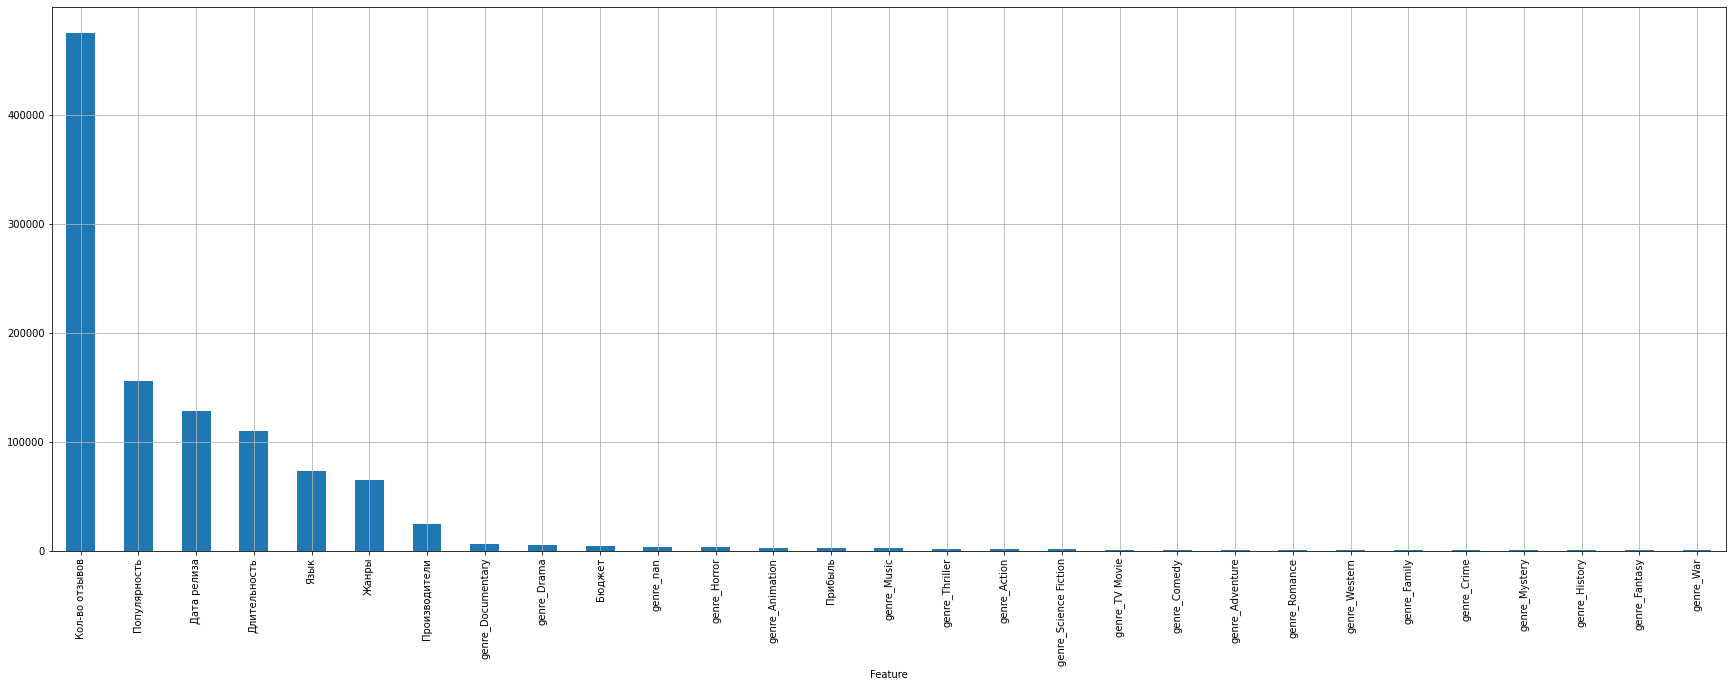

In [31]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
top_3_features = fast_fi['Feature'].values[:3]
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [32]:
fast_fi.head()

,Feature,Importance
0,Кол-во отзывов,475387.880208
1,Популярность,155872.650142
2,Дата релиза,127909.501239
3,Длительность,110062.479156
4,Язык,72720.727179


In [ ]:
#%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 4. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [34]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred[:10]}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 1.1119626e-04],
       [ 6.9836912e+00],
       [ 5.0787916e+00],
       [-6.3805520e-03],
       [-1.4231394e-07],
       [ 8.0792660e-08],
       [-1.4294294e-04],
       [ 5.1703835e+00],
       [ 6.0861902e+00],
       [ 6.1515681e-03]], dtype=float32)
Shape = (13076, 1)


In [35]:
submission[TARGET_NAME] = np.clip(test_pred.data[:, 0], 0, None)
submission.to_csv('lightautoml_tabularautoml.csv', index = False)
submission

,ID,Средний рейтинг
0,881783,1.111963e-04
1,507769,6.983691e+00
2,160064,5.078792e+00
3,802763,0.000000e+00
4,339029,0.000000e+00
...,...,...
13071,689302,6.327456e-05
13072,565536,7.016068e+00
13073,493534,5.611053e+00
13074,388875,6.473909e+00
